In [1]:
import re
import pandas as pd 
import numpy as np 
from aerobot.io import RESULTS_PATH, MODELS_PATH, DATA_PATH, load_fasta, save_fasta
from aerobot.contigs import *
from aerobot.dataset import dataset_clean_features, dataset_load, dataset_clean, dataset_load_feature_order
# from aerobot.kmer import kmer_sequence_to_kmers
from aerobot.ncbi import ncbi_download_genomes
from Bio import SeqIO
import os 
from aerobot.models import GeneralClassifier, Nonlinear
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import subprocess
from typing import List, Tuple
from aerobot.kmer import kmer_count_fasta, kmer_count_dataframe

import warnings
warnings.simplefilter('ignore')

%load_ext autoreload 
%autoreload 2

In [2]:
BS_PATH = os.path.join(DATA_PATH, 'black_sea')
SCRIPTS_PATH = os.path.join('..', 'scripts')

Initially, I tried using trained models to make predictions for Black Sea contigs, without much success. I have a feeling one major reason for this is the Z-score standardization approach used for the model, which is skewing the contig vectors.

Regardless, it seems more useful to test contig-based predictions on genomes for which we know the metabolic label, i.e. contigs derived from genomes in the testing data. To this end, we can generate artificial contigs of varying lengths from complete genomes in the test set. 

Mean contig length: 7224
Maximum contig length: 418685
Minimum contig length: 2500 

7934 of 54546 contigs exceed maximum length 10000.


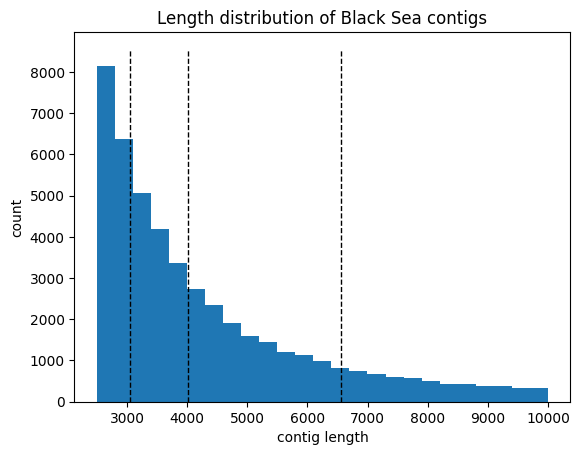

In [3]:
# First want to figure out what contig lengths are reasonable. I'll base this on the contig lengths in the Black Sea data, 
# as we already have those downloaded.
contig_lengths = []
for record in SeqIO.parse(os.path.join(BS_PATH, 'bs_contigs.fna'), 'fasta'):
    contig_lengths.append(len(record.seq))

print('Mean contig length:', int(np.mean(contig_lengths)))
print('Maximum contig length:', max(contig_lengths))
print('Minimum contig length:', min(contig_lengths), '\n')

quantiles = np.quantile(contig_lengths, [0.25, 0.5, 0.75])

# Remove outliers to make the distribution look nicer. 
max_contig_length = 10000
contig_lengths = np.array(contig_lengths)

print(np.sum(contig_lengths >= max_contig_length), f'of {len(contig_lengths)} contigs exceed maximum length {max_contig_length}.')
contig_lengths = contig_lengths[contig_lengths < max_contig_length]

# Plot a distribution of contig lengths. 
fig, ax = plt.subplots()

ax.hist(contig_lengths, bins=25)#, log=True)
ax.set_xlabel('contig length')
# ax.set_ylabel('log(count)')
ax.set_ylabel('count')
ax.set_title('Length distribution of Black Sea contigs')

ax.vlines(quantiles, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='black', linewidth=1, linestyles='--')

plt.show()


Based on the distribution of contig lengths from the Black Sea data, it seems reasonable to try a range of values from 1000 to 10000. Perhaps 1000, 3000, 5000, 7000, 9000 for now!

To start the analysis, we need to download a set of genomes from the testing set, which can be done using the `download-genome` script. I will go ahead and save these genomes in the directory specified by the `CONTIG_PATH` variable. 

In [5]:
# Get a list of genomes to download. Start with 10 from each metabolic category. 
validation_dataset = dataset_load(os.path.join(DATA_PATH, 'updated_validation_datasets.h5'), feature_type=None) # Feature type doesn't matter here, just using the labels. 
validation_dataset = dataset_clean(validation_dataset) # Clean up the dataset a bit (e.g. fix the labels)
validation_metadata_df = validation_dataset['labels'] 

# checkm_completeness_df = validation_metadata_df[['checkm_completeness']]
ncbi_assembly_levels = validation_metadata_df['ncbi_assembly_level'].fillna('None')
validation_metadata_df = validation_metadata_df[ncbi_assembly_levels.str.fullmatch('Complete Genome')] # Filter for the genomes which are complete. 
validation_labels = validation_metadata_df.physiology.values

print(len(validation_metadata_df), 'total complete genomes contained in the validation dataset.')
for label in ['aerobe', 'anaerobe', 'facultative']:
    print(f'\t{np.sum(validation_labels == label)} complete {label} genomes')

complete_genome_ids = validation_metadata_df.index.values.tolist()

160 total complete genomes contained in the validation dataset.
	82 complete aerobe genomes
	56 complete anaerobe genomes
	22 complete facultative genomes


One thing that might be worth noting is that genomes wfor which no results are found in the NCBI database are marked as "Suppressed," which I think is due to quality concerns with the genome. These (I don't think) can be downloaded through Entrez, nor do I think we should. Perhaps we should also consider... not training using these genomes? Or handling them somehow. 

In [ ]:
# _ = ncbi_download_genomes(complete_genome_ids) # Download all genome IDs to the GENOMES_PATH if they are complete.

In [12]:
downloaded_genome_ids = [filename.replace('.fasta', '') for filename in os.listdir(GENOMES_PATH)]
print(len(downloaded_genome_ids), 'complete genomes successfully downloaded from NCBI.')

downloaded_genomes_df = validation_metadata_df.loc[downloaded_genome_ids]
downloaded_genomes_df = downloaded_genomes_df[['physiology']].rename(columns={'physiology':'label'})
# Write the genome labels to a DataFrame. 
downloaded_genomes_df.to_csv(os.path.join(CONTIG_PATH, 'genomes.csv'))

138 complete genomes successfully downloaded from NCBI.


From the Prodigal [documentation](https://github.com/hyattpd/prodigal/wiki/advice-by-input-type#metagenomes):

"The simplest approach for metagenomes is to put all the sequences in one FASTA file and analyze them in Anonymous Mode. This will produce reasonable results (about 95% as good as if Prodigal had been trained on the actual genomes). It also has the advantage of being easily parallelized, as each sequence in the file can be processed independently from any other sequence in the file.

A more ideal solution, when possible, is to assemble as many genomes as you can from the sample, put each genome into a FASTA file, and analyze each genome using Normal Mode. You can then analyze the leftovers using anonymous mode."

In [ ]:
# One thing I noticed about the genome for which poor predictions were generated is that the k-mer overlap was poor between the genome and training data. 